### Solve a simple 2D stationary Navier-Stokes equation using PINN
The PDE is
$$\mu \big(\partial_{xx} u + \partial_{yy} u) = \partial_x p + u \partial_{x} u + w\partial_y u $$
and
$$\mu \big(\partial_{xx} w + \partial_{yy} w) = \partial_y p + u \partial_{x} w + w\partial_y w $$
and imcompressibility constraint:
$$\partial_x u + \partial_y w = 0.$$

When the pressure $p(x, y) = Gx$, the boundary condition is $u(x,y=0) = u(x,y=1) = 0$, one solution is
$$
u(x,y) = \frac{G}{2\mu} \big(y(y-1)\big),\qquad w(x, y) = 0.$$
This is known as the Plane Poiseuille Flow.

We consider the domain $(0,1)\times (0,1)$ for simplicity.

**Refs:** Deville MO (2022) Exact Solutions of the Navier–Stokes Equations, In: Deville MO (Ed.), An Introduction to the Mechanics of Incompressible Fluids, Cham, Springer International Publishing, 51–89.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import optim, autograd
from tqdm import tqdm
from chp08_nn import *
import copy
import matplotlib.pyplot as plt 
import numpy as np

# PDE model
μ = 1
G = 2.0
# the pressure
Px = lambda x : G*torch.ones_like(x)

## setup neueral network
input_size=2
hidden_size=60
output_size=2

torch.manual_seed(1);
model = DeepRitz(input_size, hidden_size, output_size)

lr = 1.0e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
num_bc_sample = 100
num_sample = 100
xgrid_sample = np.linspace(0,1,num_bc_sample)

# the domain
xmin = 0
xmax = 1
ymin = 0
ymax = 1

# unit vector
e1 = torch.tensor([1,0])
e2 = torch.tensor([0,1])

# training parameters
eps = 0.005
EPOCH = 20000
λ = 500 
loss_vec = np.zeros(EPOCH)

In [2]:
bar = tqdm(range(EPOCH))
model.train()
for j in bar:
    bar.set_description("Training Epoch " + str(j))

    optimizer.zero_grad()
    
    xr = torch.rand(num_sample,input_size)
    xr[:,0] *= (xmax - xmin - 2*eps) 
    xr[:,0 ] += xmin + eps
    xr[:,1] *= xr[:,1] * (ymax - ymin - 2*eps) 
    xr[:,1] += ymin + eps
    xr._requires_grad=True
    output_r = model(xr)

    u = output_r[:,0]
    w = output_r[:,1]
    dd = (model(xr + eps * e1) + model(xr - eps * e1) - 2 * model(xr))/eps**2
    uxx = dd[:,0]
    wxx = dd[:,1]
    dd = (model(xr + eps * e2) + model(xr - eps * e2) - 2 * model(xr))/eps**2
    uyy = dd[:,0]
    wyy = dd[:,1]
    dd = (model(xr + eps * e1) - model(xr - eps * e1))/(2*eps)
    ux = dd[:,0]
    wx = dd[:,1]
    dd = (model(xr + eps * e2) - model(xr - eps * e2))/(2*eps)
    uy = dd[:,0]
    wy = dd[:,1]
    loss_r = torch.mean(torch.pow(μ*(uxx + uyy) - Px(xr[:,0]) - u*ux - w*uy,2))
    loss_r += torch.mean(torch.pow(μ*(wxx + wyy) - 0 - u*wx - w*wy,2))
    loss_r += torch.mean(torch.pow(ux + wy,2))
    
    # boundary
    xb = torch.zeros(num_bc_sample,2)
    xb[:,0] = torch.tensor(xgrid_sample)
    xb._requires_grad=True
    output_b = model(xb)
    loss_b = torch.mean(torch.pow(output_b, 2))
    
    xb = torch.ones(num_bc_sample,2)
    xb[:,0] = torch.tensor(xgrid_sample)
    xb._requires_grad=True
    output_b = model(xb)
    loss_b += torch.mean(torch.pow(output_b, 2))
    
    loss = loss_r + λ * loss_b
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_vec[j] = loss.item()

Training Epoch 19999: 100%|██████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.39it/s]


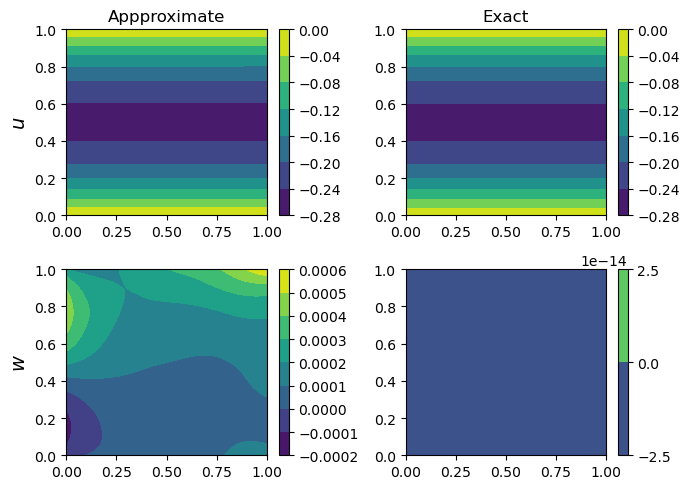

In [3]:
feature_x = np.array(np.linspace(0,1,100),dtype=np.float32)
feature_y = np.array(np.linspace(0,1,100),dtype=np.float32)
[X, Y] = np.meshgrid(feature_x, feature_y)
U = 0*X; W = 0*X

for i in range(np.size(X,0)):
    for j in range(np.size(X,1)):
        input_tensor = torch.tensor([X[i,j], Y[i,j]]).view(-1,2)
        output = model(input_tensor).detach().numpy()[0,:]
        U[i,j] = output[0]
        W[i,j] = output[1]
exact_U = G/2*Y*(Y-1)
exact_W = 0.0 * X

plt.figure(figsize=(7,5))
plt.subplot(221)
plt.contourf(X, Y, U)
plt.ylabel('$u$', fontsize=14);
plt.colorbar()
plt.title('Appproximate')

plt.subplot(222)
plt.contourf(X, Y, exact_U)
plt.colorbar()
plt.title('Exact')


plt.subplot(223)
plt.contourf(X, Y, W)
plt.ylabel('$w$',fontsize=14);
plt.colorbar()

plt.subplot(224)
plt.contourf(X, Y, exact_W)
plt.colorbar()

plt.tight_layout()
plt.show()